The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time

* ## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* ## Apply a distortion correction to raw images.

In [2]:
%matplotlib qt
# img = cv2.imread(camera_cal_images[8]) 
# plt.imshow(img)

# prepare object points
nx = 9
ny = 6

#Prep Object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

camera_cal_images = glob.glob('camera_cal\\calibration*.jpg') 

#Iterate over images
for idx, img in enumerate(camera_cal_images):
    fname = img
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

In [3]:
import pickle
%matplotlib inline

for idx, img in enumerate(camera_cal_images):
    fname = img
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal\\undist_'+ fname.split('\\')[1] ,dst)
    
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(dst)
# ax2.set_title('Undistorted Image', fontsize=30)


Text(0.5,1,'Undistorted Image')

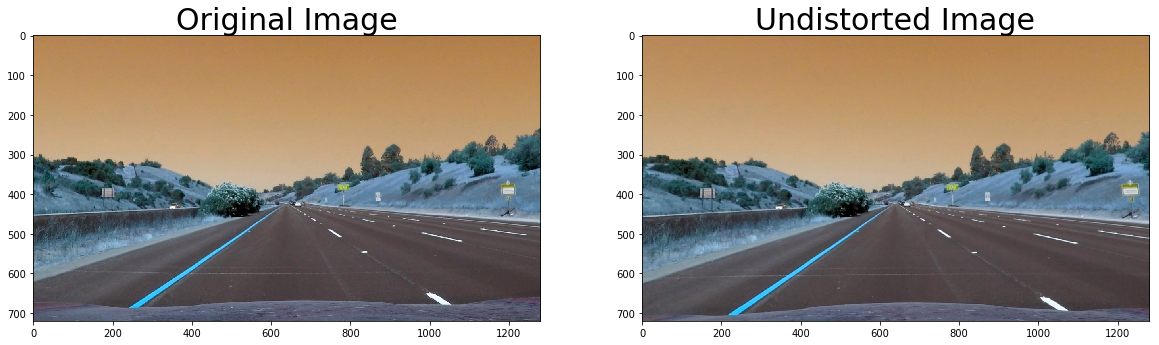

In [4]:
img = cv2.imread('test_images\\straight_lines1.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open('dist_pickle.p', 'wb'))
dist_pickle = pickle.load(open('dist_pickle.p', 'rb'))
dist_pickle["mtx"]


def reset():

    coeff_pickle = {}
    coeff_pickle["imageCount"] = 0   
    coeff_pickle["left_fit"] = []
    coeff_pickle["right_fit"] = []
    coeff_pickle["leftx"] = []
    coeff_pickle["lefty"] = []
    coeff_pickle["rightx"] = []
    coeff_pickle["righty"] = [] 
    coeff_pickle["left_lane_inds"] = []
    coeff_pickle["right_lane_inds"] = []
    coeff_pickle["avgRx"] = []
    coeff_pickle["shadesFlag"] = 0
    pickle.dump(coeff_pickle, open("co-officients.p", 'wb'))

reset()

Functions for the pipeline

In [6]:

###################################################


def getBinaryWarpedImage(test_image, combined_binary, src, dst, M, shouldRun=0):
       
    ts = time.gmtime()
    M = cv2.getPerspectiveTransform(src, dst)   
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
      
    if(shouldRun == 1):            

        f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(test_image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(binary_warped)
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)        

    return binary_warped

###################################################

def sobel_operation(img, thresh=(20, 100)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary

###################################################

def hls_operation(img, thresh=(60, 255)):
        
    # 1) Convert to HLS color space
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = imgHLS[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0]) & (S<=thresh[1])] = 1
    
    return binary_output

def plot(test_image, modified_img, text):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified_img, cmap='gray')
    ax2.set_title(text, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
###################################################

In [7]:
def isShadesPresent(img):
    
    rowcount = 0
    
    for i in range(0, img.shape[1]):

        row = img[i:i+1]
        row = np.squeeze(row)

        onescount = 0
        for j in range(0, len(row)):
            if(row[j] == 1):
                onescount = onescount + 1

        if(onescount > 1000):
              rowcount = rowcount + 1
    
    if(rowcount > 10):
        #print("True")
        return True
    else:
        #print("False")
        return False
         

In [8]:
def FindLanes(binary_warped):
     
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
  

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        if(len(good_right_inds) == 0):
            while(len(good_right_inds) == 0 and rightx_current <= binary_warped.shape[1]):
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (255,0,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (255,0,0), 2) 
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                rightx_current = rightx_current + 100

          
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
  

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, np.mean(rightx)


In [9]:
def getLaneInfo(binary_warped,LA,LB,LC,RA,RB,RC):
        
    ##################################################
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 100

    left_lane_inds = ((nonzerox > (LA*(nonzeroy**2) + LB*nonzeroy + LC - margin)) & 
              (nonzerox < (LA*(nonzeroy**2) + LB*nonzeroy + LC + margin))) 

    right_lane_inds = ((nonzerox > (RA*(nonzeroy**2) + RB*nonzeroy + RC - margin)) & 
               (nonzerox < (RA*(nonzeroy**2) + RB*nonzeroy + RC + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, np.mean(rightx)
    

In [10]:
def visualize(left_fitx, right_fitx, binary_warped, left_lane_inds, right_lane_inds, ploty, shouldRun = 0):
    
    if(shouldRun == 1):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

            # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    return None


In [18]:
def fitPolynomial(test_image, binary_warped, src, dst, isShadesPresentFlag, shouldRun=0): 
        
    
    coeff_pickle = pickle.load(open("co-officients.p", 'rb'))     
    
    imageCount = coeff_pickle["imageCount"]
    imageCount = imageCount + 1
    coeff_pickle["imageCount"] = imageCount
    
    left_fit = coeff_pickle["left_fit"] 
    right_fit = coeff_pickle["right_fit"]  
    leftx = coeff_pickle["leftx"] 
    lefty = coeff_pickle["lefty"]
    rightx = coeff_pickle["rightx"] 
    righty = coeff_pickle["righty"]  
    left_lane_inds = coeff_pickle["left_lane_inds"]   
    right_lane_inds = coeff_pickle["right_lane_inds"]  
    avgRXSaved = coeff_pickle["avgRx"] 
    
        
    if(imageCount == 1):
        left_fit,right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, avgRX = FindLanes(binary_warped)  
        coeff_pickle["left_fit"] = left_fit
        coeff_pickle["right_fit"] = right_fit
        coeff_pickle["leftx"] = leftx
        coeff_pickle["lefty"] = lefty
        coeff_pickle["rightx"] = rightx
        coeff_pickle["righty"] = righty
        coeff_pickle["left_lane_inds"] = left_lane_inds
        coeff_pickle["right_lane_inds"] = right_lane_inds
        coeff_pickle["avgRx"] = avgRX
      
    else:
        #binary_warped,LA,LB,LC,RA,RB,RC
        if(isShadesPresentFlag == False):
                coeff_pickle["shadesFlag"] = 0
                left_fit,right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, avgRX = getLaneInfo(binary_warped,left_fit[0],left_fit[1],left_fit[2],right_fit[0],right_fit[1],right_fit[2])             
                if(abs(avgRXSaved - avgRX) >= 50):
                       left_fit,right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, avgRX = FindLanes(binary_warped)  
                   
        else:
                coeff_pickle["shadesFlag"] = 1
                left_fit,right_fit, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, avgRX = FindLanes(binary_warped)  
                #print("shades present")
        
        coeff_pickle["left_fit"] = left_fit
        coeff_pickle["right_fit"] = right_fit
        coeff_pickle["leftx"] = leftx
        coeff_pickle["lefty"] = lefty
        coeff_pickle["rightx"] = rightx
        coeff_pickle["righty"] = righty
        coeff_pickle["left_lane_inds"] = left_lane_inds
        coeff_pickle["right_lane_inds"] = right_lane_inds
        coeff_pickle["avgRx"] = avgRX
     
    
    
    ##### ###################################### position of the vehicle with respect to center in the lane #################
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    midpointlane = (leftx_base +  rightx_base) //2
    
    CENTER_OF_THE_IMAGE_MTS = binary_warped.shape[1]//2* xm_per_pix 
    
    MIDPOINT_LANE_MTS = midpointlane * xm_per_pix
    
    OFFSET = abs(CENTER_OF_THE_IMAGE_MTS-MIDPOINT_LANE_MTS)
 
    
    y_eval = binary_warped.shape[0]   
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) #represent x values to generate y for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
       
    visualize(left_fitx, right_fitx, binary_warped, left_lane_inds, right_lane_inds, ploty, shouldRun)
   
    
    left_curverad_raw = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad_raw = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    lyp=lefty*ym_per_pix
    lxp=leftx*xm_per_pix   
    
    ryp=righty*ym_per_pix
    rxp=rightx*xm_per_pix
        
    left_fit_cr  = np.polyfit(lyp,lxp,2)
    right_fit_cr = np.polyfit(ryp,rxp,2)
    
    ################################################### ROC #######################################################################
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]) 
    
    #print(left_curverad, 'm', right_curverad, 'm')

    ##########################################################################################################################
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
   
    
    ImageText = 'Radius of Curvature = ' + "{0:.2f}".format(left_curverad) + 'm | OFFSET = ' + "{0:.2f}".format(OFFSET) + 'm'
      
    cv2.putText(test_image,
        ImageText, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    ################################## DRAW THE AREA where the lane is found ##########################################
        
    MInv = cv2.getPerspectiveTransform(dst, src)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(test_image, 1, newwarp, 0.3, 0)
  
  #     sourceImageName = 'sourceimages\\frame{0}.jpg'.format(imageCount)   
  #     cv2.imwrite(sourceImageName,test_image)

  #     FinalImageName = 'finalimages\\frame{0}.jpg'.format(imageCount) 
  #     cv2.imwrite(FinalImageName,result)

    pickle.dump(coeff_pickle,open("co-officients.p", 'wb'))
        
    return result


## pipeline

In [19]:

def pipeline(test_image, source, destination, Matrix, dist, shouldRun=0):   
        
    undist_test_image = cv2.undistort(test_image, Matrix, dist, None, Matrix)    
        
    sobelOp = sobel_operation(undist_test_image, thresh=(20, 100)) 
    
    if(shouldRun == 1):
        plot(test_image, sobelOp, " threshold gradients")  
    
    hlsOp = hls_operation(test_image, thresh=(60, 255)) 
    
    if(shouldRun == 1):
        plot(test_image, hlsOp, 'threshold colors - s channel')
    
    combined_binary = np.zeros_like(sobelOp) 
    
    combined_binary[(hlsOp == 1) | (sobelOp == 1)] = 1
    
    if(shouldRun == 1):
        plot(test_image, combined_binary, 'Combined gradient + colors')
    
    binary_warped = getBinaryWarpedImage(test_image, combined_binary, source, destination, Matrix, shouldRun)
    
    isShadesPresentFlag = isShadesPresent(binary_warped)
    
    if(shouldRun == 1):
        plot(test_image, binary_warped, 'Combined gradient + colors')
    
    final = fitPolynomial(test_image, binary_warped, source, destination, isShadesPresentFlag)   
    
    return final
    

In [20]:
def process_image(image):
  
    M = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    coeff_pickle = pickle.load(open("co-officients.p", 'rb'))    
    shadesFlag = coeff_pickle["shadesFlag"]   
    
    if(shadesFlag == 0) :
             src = np.float32([[210, 710],[600,453],[680, 453],[880,710]]) 
             dst = np.float32([[300, 710],[300, 0],[880, 0],[880,710]])
    else:
             src = np.float32([[210, 710],[600,453],[680, 453],[1100,710]]) 
             dst = np.float32([[300, 710],[300, 0],[1100, 0],[1100,710]])
 
    result = pipeline(image, src, dst, M, dist)
    
    return result

In [37]:
# #### mtx

# # Read in an image, you can also try test1.jpg or test4.jpg
# #test_image = cv2.imread('test_images\\straight_lines1.jpg')

# #test_image = cv2.imread('test_images\\straight_lines2.jpg')
# #test_image = cv2.imread('test_images\\test1.jpg')
# #test_image = cv2.imread('test_images\\test2.jpg')
# #test_image = cv2.imread('test_images\\test3.jpg')
# #test_image = cv2.imread('test_images\\test4.jpg')
# #test_image = cv2.imread('test_images\\test5.jpg')
# #test_image = cv2.imread('test_images\\test6.jpg')
# #test_image = cv2.imread('test_images\\test1.jpg')
# #test_image = cv2.imread('test_images\\test1.jpg')


# test_images = [ 
#                 "test_images\\test1.jpg" ,  
#                 "test_images\\test2.jpg" ,
#                 "test_images\\test3.jpg" ,  
#                 "test_images\\test4.jpg" ,
#                 "test_images\\test5.jpg" ,  
#                 "test_images\\test6.jpg",
#                 "test_images\\straight_lines1.jpg" ,  
#                 "test_images\\straight_lines2.jpg"
    
#                 ]

# reset()

# for i in range(0,len(test_images)):
# #     fig9 = plt.figure(i)
    
#     coeff_pickle = pickle.load(open("co-officients.p", 'rb'))  
    
#     shadesFlag = coeff_pickle["shadesFlag"]
    
#     if(shadesFlag == 0) :
#              src = np.float32([[210, 710],[600,453],[680, 453],[880,710]]) 
#              dst = np.float32([[300, 710],[300, 0],[880, 0],[880,710]])
#     else:
#              src = np.float32([[210, 710],[600,453],[680, 453],[1100,710]]) 
#              dst = np.float32([[300, 710],[300, 0],[1100, 0],[1100,710]])
 

#     print(shadesFlag)   
    
#     test_image = cv2.imread(test_images[i])
#     finalimage = pipeline(test_image, src, dst, mtx, dist, 0)
#     cv2.imwrite(test_images[i][:-4] + "marked.jpg", finalimage)
   

#     #binary_warped = debugPipleline(test_image, src, dst, mtx)
#     plt.imshow(finalimage)


## Use color transforms, gradients, etc., to create a thresholded binary image.
## Apply a perspective transform to rectify binary image ("birds-eye view").

In [29]:
reset()
###############

white_output = 'project_video_op_final.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_op_final.mp4
[MoviePy] Writing video project_video_op_final.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [40:15<00:02,  2.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_op_final.mp4 

Wall time: 40min 17s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))